# Starting the Ammonia Kinematics Project

To start, I'll just import a bunch of the packages that I know I'll need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io
from astropy.io import fits
import pandas as pd
import matplotlib as mpl
from astropy import wcs
from astropy.coordinates import SkyCoord
import pickle
import math
from scipy.optimize import curve_fit
#import gausspyplus

import os

%matplotlib inline
import matplotlib.pyplot as plt

#from gausspyplus.prepare import GaussPyPrepare
#from gausspyplus.decompose import GaussPyDecompose

Next let's open up the velocity 1 posterior file. This gives a probability distribution funciton showing the probability that the ammonia gas is at each velocity. (From Brian Svoboda)

In [2]:
path = 'v1_voff_post.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header
print(header)

wcs_velocities = wcs.WCS(header)
print(wcs_velocities)
print(data.shape)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 2200                                                  NAXIS2  =                  800                                                  NAXIS3  =                  199                                                  CDELT1  =      -0.001666666707                                                  CDELT2  =       0.001666666707                                                  CRPIX1  =               1100.0                                                  CRPIX2  =               9785.0                                                  CRVAL1  =        170.233333333                                                  CRVAL2  =                  0.0                                                  CTYPE1  = 'GLON-SFL'                    

Next, we define the velocity channels and plot a single random pixel to see what the probability distributions look like. Then we go through pixel by pixel and take the highest probability velocity at each pixel and save them to a grid system to plot in a map. We still need to go through and save this to a new .fits file for Megan

0.020100486924400585 kms
1.0
0.000559298
0.0693021
5.094974102757829
(800, 2200)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


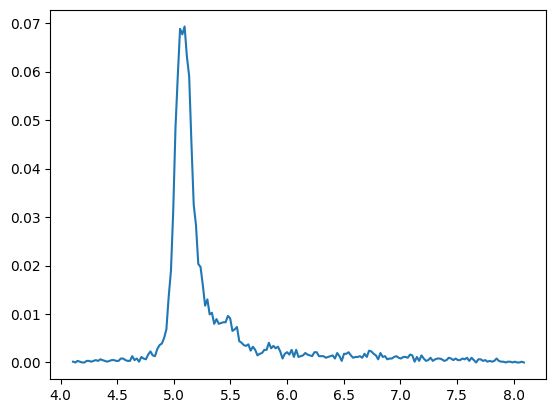

In [3]:
vel_start = header["CRVAL3"]
vel_inc = header["CDELT3"]

v_channels = np.arange(header["NAXIS3"])

#define velocity as km/s blocks
velocity = vel_start + (vel_inc * v_channels)
velocity = np.array(velocity, dtype = float)

print(velocity[1]-velocity[0], 'kms')

posterior_dist = data[:, 75, 1400]
print(np.sum(posterior_dist))

plt.plot(velocity, posterior_dist)
print(np.std(posterior_dist[100:190]))

print(np.max(posterior_dist))
print(velocity[list(posterior_dist).index(np.max(posterior_dist))])

image = data[:, :, :]
max_post = np.max(data[:, :, :], axis = 0)
print(max_post.shape)
print(max_post)

velocity_grid = []
for i in range(800):
    row_number = []
    for j in range(2200):
        posterior_dist = data[:, i, j]
        if math.isnan(max_post[i, j]):
            row_number.append(max_post[i,j])
        else:
            #print(velocity[list(posterior_dist).index(max_post[i, j])])
            row_number.append(velocity[list(posterior_dist).index(max_post[i, j])])
    velocity_grid.append(row_number)

Now we plot that grid in galactic coordinates.

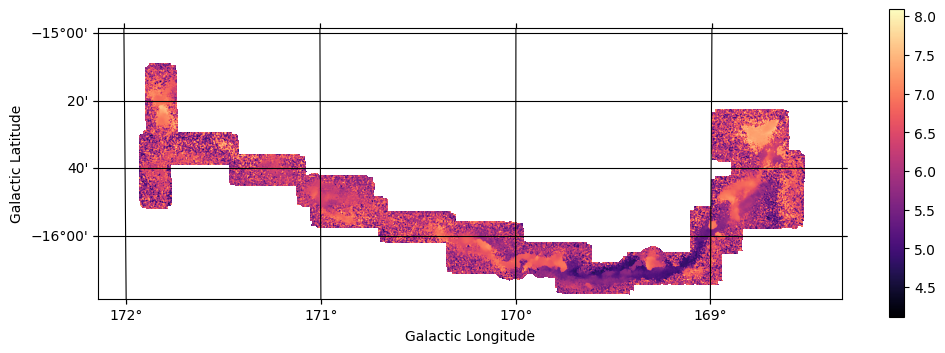

In [4]:
#image = data[112, :, :]

plt.figure(figsize = [12,4])
ax = plt.subplot(projection=wcs_velocities, slices=('x', 'y', 0))
#cm = plt.cm.get_cmap('bwr_r')
plt.imshow(velocity_grid, origin = 'lower', cmap = 'magma')
plt.colorbar()
plt.grid()

ax.coords.grid(True, color='black', ls='solid')
ax.coords[0].set_axislabel('Galactic Longitude')
ax.coords[1].set_axislabel('Galactic Latitude')

output_hdu = wcs_velocities.to_fits()
output_hdu[0].data is None

output_hdu[0].data = velocity_grid

output_hdu.writeto("column_density.fits", overwrite=True)

(1793, 1962) (184, 356)
(199, 172, 169)
(slice(0, 199, None), slice(184, 356, None), slice(1793, 1962, None))
WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SFL' 'GLAT-SFL' 'v' 
CRVAL : np.float64(170.233333333) np.float64(0.0) np.float64(4.1100502434622) 
CRPIX : np.float64(-693.0) np.float64(9601.0) np.float64(0.0) 
PC1_1 PC1_2 PC1_3  : np.float64(1.0) np.float64(0.0) np.float64(0.0) 
PC2_1 PC2_2 PC2_3  : np.float64(0.0) np.float64(1.0) np.float64(0.0) 
PC3_1 PC3_2 PC3_3  : np.float64(0.0) np.float64(0.0) np.float64(1.0) 
CDELT : np.float64(-0.001666666707) np.float64(0.001666666707) np.float64(0.02010048692440058) 
NAXIS : 169  172  199


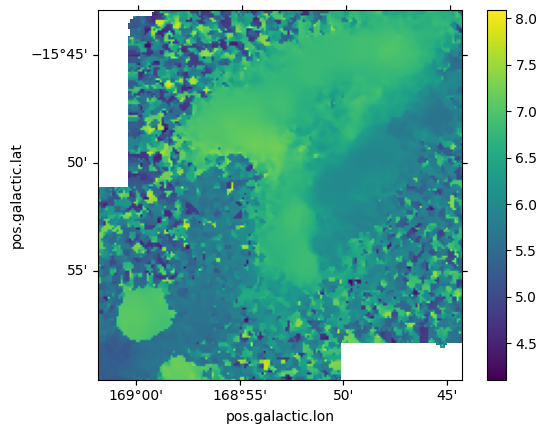

In [5]:
l_ll, b_ll = 169.03, -16.00
l_ur, b_ur = 168.74, -15.715

(xmin, ymin, vel), (xmax, ymax, vel) = wcs_velocities.wcs_world2pix([[l_ll, b_ll, 5.094974102757829], [l_ur, b_ur, 5.094974102757829]], 0)
(xmin, ymin, vel), (xmax, ymax, vel)

ax = plt.subplot(projection=wcs_velocities, slices=('x', 'y', 0))
im = ax.imshow(velocity_grid)
plt.colorbar(im)
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

xmin_int, xmax_int = int(np.floor(xmin)), int(np.ceil(xmax))
ymin_int, ymax_int = int(np.floor(ymin)), int(np.ceil(ymax))
print((xmin_int, xmax_int), (ymin_int, ymax_int))

subregion = data[0:199, ymin_int:ymax_int,xmin_int:xmax_int]
print(subregion.shape)

slices = (slice(0, 199), slice(ymin_int, ymax_int), slice(xmin_int, xmax_int))
print(slices)

new_wcs = wcs_velocities.slice(slices)
print(new_wcs)

#output_hdu = new_wcs.to_fits()
output_hdu[0].data = subregion
output_hdu.writeto("B10_ML_Column_Density.fits", overwrite=True)

What I would like to do next is to build some cubelets to analyze each section individually. Check the sky coordinates info tab to see how to do this. Let's start by working on B211. From there, see if you can fit Gaussians to at least two peaks and see how that changes things.

2200
gx = -4.286844503883193e-05 -1.939696988204656 1.8090438231960522 0.4109542831091383
gy = [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/tmp/ipykernel_253748/1545861743.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('bwr_r')
/tmp/ipykernel_253748/1545861743.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('Grays')
/tmp/ipykernel_253748/1545861743.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('Grays')


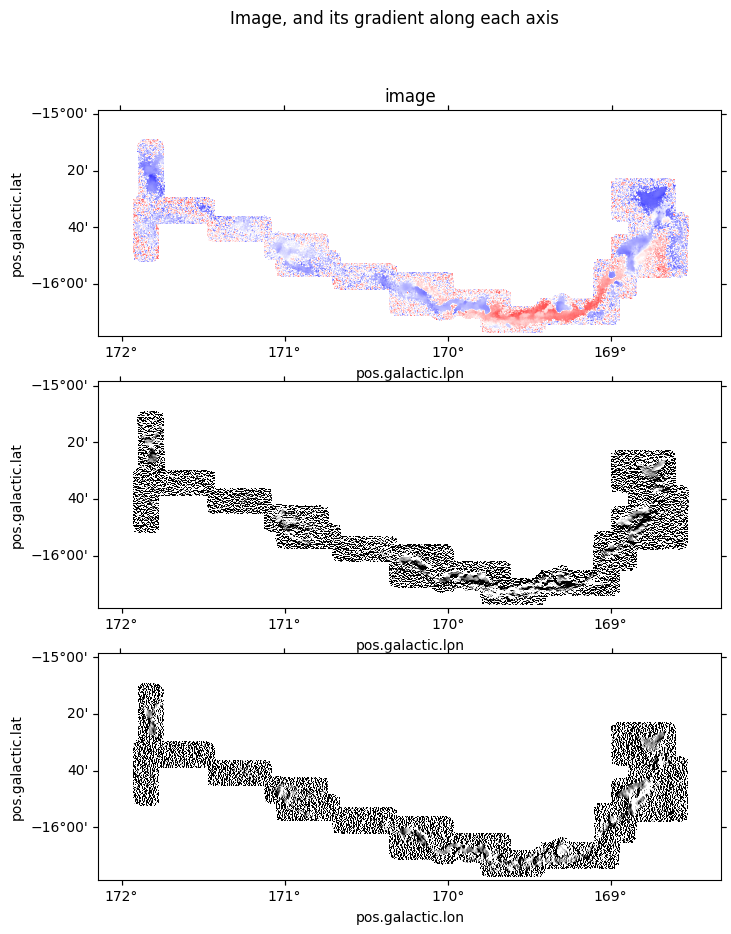

In [6]:
# compute gradient of image
print(len(velocity_grid[0]))
gx, gy = np.gradient(velocity_grid)
print("gx =", np.nanmean(gx), np.nanmin(gx), np.nanmax(gx), np.nanstd(gx))
print("gy =", gy)

# plotting
plt.close("all")
plt.figure(figsize = [12, 10])
plt.suptitle("Image, and its gradient along each axis")
ax = plt.subplot(311, projection = wcs_velocities, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('bwr_r')
ax.imshow(velocity_grid, origin = 'lower', cmap = cm)
ax.set_title("image")

a = 0.05
ax = plt.subplot(312, projection = wcs_velocities, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('Grays')
ax.imshow(gx, origin = 'lower', cmap = cm, vmin = np.nanmean(gx) - a*np.nanstd(gx), vmax = np.nanmean(gx) + a*np.nanstd(gx))
#ax.set_title("gx")

ax = plt.subplot(313, projection = wcs_velocities, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('Grays')
ax.imshow(gy,origin = 'lower', cmap = cm, vmin = np.nanmean(gy) - a*np.nanstd(gy), vmax = np.nanmean(gy) + a*np.nanstd(gy))
#ax.set_title("gy")
#plt.show()

plt.savefig('Gradient_Decomp.png', bbox_inches = 'tight')

In [7]:
path = 'HGBS_tauN3_skeleton_map.fits.gz'
cube = fits.open(path)
skeleton_data = cube[0].data
header = cube[0].header
print(header)

wcs_skeleton = wcs.WCS(header)
print(wcs_skeleton)
print(data.shape)

SIMPLE  =                    T / Written by IDL:  Tue Jan 15 09:47:57 2019      BITPIX  =                  -32 / Number of bits per data pixel                  NAXIS   =                    2 / Number of data axes                            NAXIS1  =                 8500 /Number of positions along axis 1                NAXIS2  =                 7200 /Number of positions along axis 2                CTYPE1  = 'RA---TAN'           / Coordinate Type                                CTYPE2  = 'DEC--TAN'           / Coordinate Type                                EQUINOX =                 2000 /Equinox of Ref. Coord.                          CDELT1  =         -0.000833333 / Degrees / Pixel                                CDELT2  =          0.000833333 / Degrees / Pixel                                CROTA2  =              0.00000 / Rotation Angle (Degrees)                       CRPIX1  =            4250.5000 / Reference Pixel in X                           CRPIX2  =            3600.5000 / Referen

/tmp/ipykernel_253748/618568361.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('Grays')


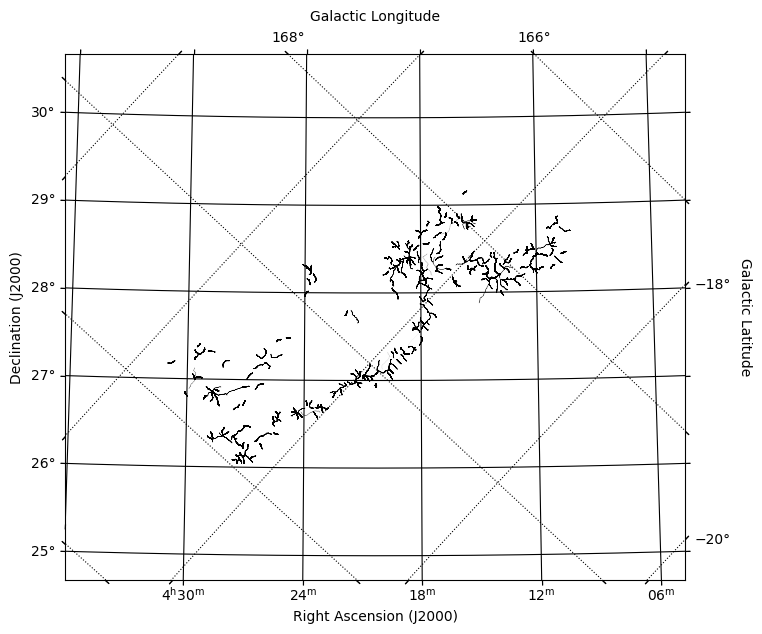

In [8]:
plt.figure(figsize = [8, 10])

ax = plt.subplot(projection=wcs_skeleton, slices=('x', 'y'))
cm = plt.cm.get_cmap('Grays')
ax.imshow(skeleton_data, origin = 'lower', cmap = cm, vmin = 0, vmax = 0.9)

ax.coords.grid(True, color='black', ls='solid')
ax.coords[0].set_axislabel('Right Ascension (J2000)')
ax.coords[1].set_axislabel('Declination (J2000)')

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='black', ls='dotted')
overlay[0].set_axislabel('Galactic Longitude')
overlay[1].set_axislabel('Galactic Latitude')

In [9]:
coordinates = []
for i in range(1, 267):
    #print(len(np.argwhere(data[:, :] == i)))
    coordinates.append(np.argwhere(skeleton_data[:, :] == i))

In [10]:
coordinates_x = []
coordinates_y = []
for k in range(len(coordinates)):
    coordinates_i_x = []
    coordinates_i_y = []
    for i in range(len(coordinates[k])):
        coordinates_i_x.append(coordinates[k][i][0])
        coordinates_i_y.append(coordinates[k][i][1])
    coordinates_x.append(coordinates_i_x)
    coordinates_y.append(coordinates_i_y)
    
#plt.scatter(coordinates_264_x, coordinates_264_y)

In [11]:
from astropy import units as u
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
coordinates_ra = []
coordinates_dec = []
coordinates_l = []
coordinates_b = []
for i in range(len(coordinates)):
    (x, y) = wcs_skeleton.wcs_pix2world(coordinates_y[i], coordinates_x[i], 0)
    #print(min(y), max(y))
    
    skeleton_i = SkyCoord(ra = x * u.deg, dec = y * u.deg, frame='icrs')
    
    galactic_coords = skeleton_i.transform_to(Galactic())
    l = []
    b = []
    for j in range(len(galactic_coords)):
        l.append(galactic_coords.l[j].degree)
        b.append(galactic_coords.b[j].degree)
    
    #print(np.min(b), np.max(b))
    c = SkyCoord(l, b, frame='galactic', unit='deg')
    pixels_x, pixels_y = astropy.wcs.utils.skycoord_to_pixel(c, wcs = wcs_velocities, origin=1)
    
    coordinates_l.append(pixels_x)
    coordinates_b.append(pixels_y)
    #coordinates_b.append(-1*(pixels_y - 750) + 500)
    coordinates_ra.append(x)
    coordinates_dec.append(y)

/tmp/ipykernel_253748/3897529067.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('Grays')


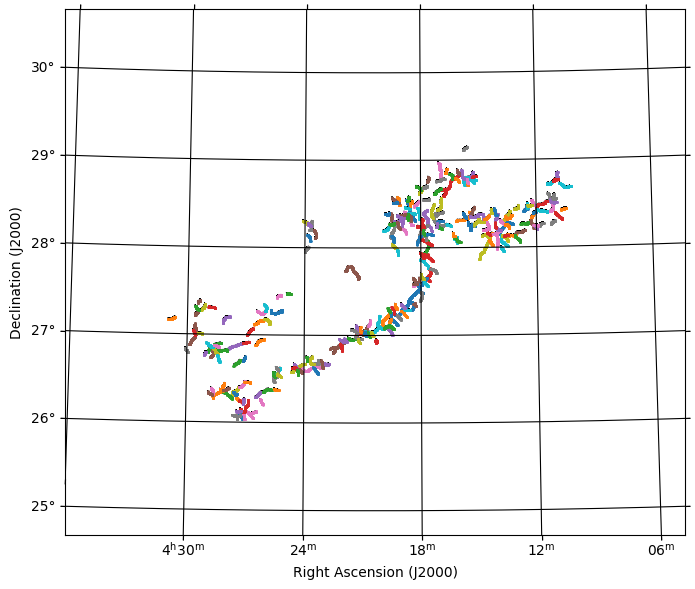

In [12]:
plt.figure(figsize = [8, 10])

ax = plt.subplot(projection=wcs_skeleton, slices=('x', 'y'))
cm = plt.cm.get_cmap('Grays')
ax.imshow(skeleton_data, origin = 'lower', cmap = cm, vmin = 0, vmax = 0.9)

ax.coords.grid(True, color='black', ls='solid')
ax.coords[0].set_axislabel('Right Ascension (J2000)')
ax.coords[1].set_axislabel('Declination (J2000)')

for i in range(len(coordinates)):
    plt.scatter(coordinates_y[i], coordinates_x[i], s = 1)

/tmp/ipykernel_253748/3527271816.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('bwr')


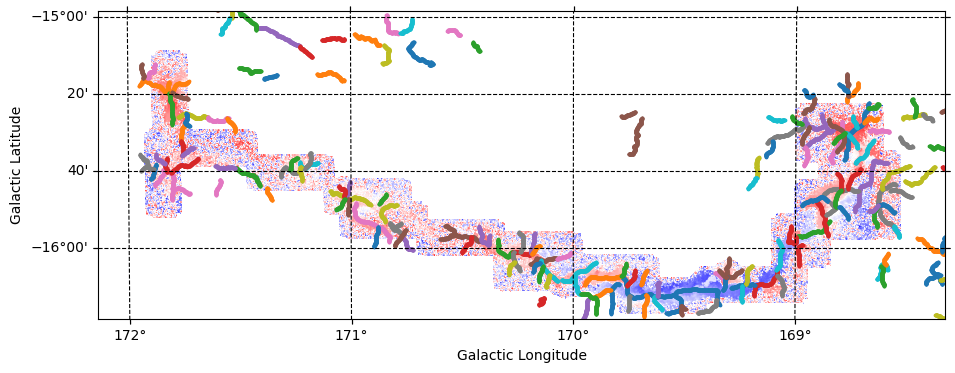

In [13]:
plt.figure(figsize = [12,4])
ax = plt.subplot(projection=wcs_velocities, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('bwr')
ax.imshow(velocity_grid, origin = 'lower', cmap = cm)
for i in range(len(coordinates)):
    ax.scatter(coordinates_l[i], coordinates_b[i], s = 3)

plt.grid()
plt.xlim(0, 2200)
plt.ylim(0, 800)

ax.coords.grid(True, color='black', ls='dashed')
ax.coords[0].set_axislabel('Galactic Longitude')
ax.coords[1].set_axislabel('Galactic Latitude')

In [14]:
path = 'velocity_grid.fits'
cube = fits.open(path)
velocity_grid_data = cube[0].data
header = cube[0].header
#print(header)

wcs_vel_grid = wcs.WCS(header)
print(velocity_grid_data.shape)

vel_coords = np.argwhere(velocity_grid_data[:, :] != math.nan)

print(len(vel_coords))
print(vel_coords[2])

(800, 2200)
1760000
[0 2]


In [15]:
indices = []
for i in range(len(coordinates)):
    avg_x = np.nanmean(coordinates_l[i])
    avg_y = np.nanmean(coordinates_b[i])
    
    if avg_x > 2100 or avg_y > 705:
        continue
    else:
        indices.append(i)
    if 1800 < avg_x < 1900:
        print(i, avg_x, avg_y)
    else:
        continue

removed = [15, 17, 20, 42, 51, 78, 79, 82, 91, 104, 105, 122, 124, 128, 129, 149, 160, 167, 172, 173, 176, 191, 195, 230, 233, 240, 241, 251, 260]

for i in removed:
    indices.remove(i)

#print(len(indices))
print(indices)

#51, 20, 21

32 1862.396286992151 226.8373385602771
33 1882.2543858389104 262.9078983158798
34 1874.2954892292796 471.01749653754854
53 1800.4679195667013 210.5595305420571
60 1861.6291630121927 306.6678991636187
75 1849.136582869108 552.7703805093224
84 1855.5975714630608 500.1638294304845
103 1819.7578201976105 167.89526557398418
126 1838.8099782366792 421.52906483743675
154 1886.9040947388685 505.8091184057795
155 1835.6696942155957 476.4494506076302
222 1812.196823022188 513.1296732477882
230 1843.2444177770046 582.3911346857406
[0, 1, 2, 4, 6, 7, 16, 18, 19, 21, 23, 25, 27, 28, 30, 32, 33, 34, 35, 36, 40, 43, 44, 47, 48, 49, 50, 52, 53, 55, 56, 58, 59, 60, 62, 63, 64, 67, 69, 70, 75, 77, 83, 84, 86, 89, 90, 97, 101, 102, 103, 107, 111, 116, 117, 123, 125, 126, 127, 130, 134, 135, 136, 137, 138, 139, 140, 141, 142, 145, 146, 147, 153, 154, 155, 157, 161, 162, 163, 174, 175, 180, 181, 185, 186, 189, 190, 192, 193, 199, 202, 203, 204, 205, 208, 210, 212, 214, 215, 216, 217, 219, 220, 221, 222, 22

/tmp/ipykernel_253748/3137465539.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('bwr')


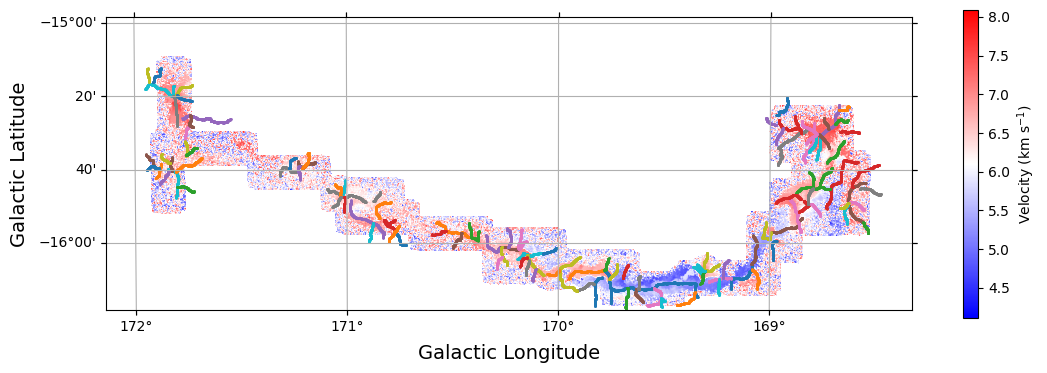

In [19]:
plt.figure(figsize = [13,4])
ax = plt.subplot(projection=wcs_velocities, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('bwr')
vel_map = ax.imshow(velocity_grid, origin = 'lower', cmap = cm)
for i in indices:
    ax.scatter(coordinates_l[i], coordinates_b[i], s = 1)

plt.grid()
plt.colorbar(vel_map, label = r'Velocity (km s$^{-1}$)')
plt.xlim(0, 2200)
plt.ylim(0, 800)

ax.coords.grid()
ax.coords[0].set_axislabel('Galactic Longitude', fontsize = 14)
ax.coords[1].set_axislabel('Galactic Latitude', fontsize = 14)
plt.savefig('Figures/velocity_map_spines.png', transparent=True, bbox_inches = 'tight')

In [17]:
saved_l = []
saved_b = []
for i in indices:
    saved_l.append(coordinates_l[i])
    saved_b.append(coordinates_b[i])

df = pd.DataFrame(data={'Galactic Longitude': saved_l,
                        'Galactic Latitude': saved_b, 
                        'Identification': indices})

display(df)

with open('spines_coordinates.pkl', 'wb') as f:  # open a text file
    pickle.dump(df, f) # serialize the list
f.close()

,Galactic Longitude,Galactic Latitude,Identification
0,"[1374.6049467614898, 1374.9450540956511, 1375....","[63.57339090692949, 63.20771265444819, 62.8420...",0
1,"[1263.3381744429716, 1263.3645154316564, 1263....","[86.97954658819435, 87.68613158724656, 88.0267...",1
2,"[1358.6537616343378, 1359.020231526174, 1359.3...","[110.12334380739776, 110.46423674785001, 110.8...",2
3,"[1965.525957507919, 1965.5523176464797, 1965.2...","[277.825780449537, 278.5324947562531, 279.6032...",4
4,"[668.2471173143755, 668.5870864210632, 669.267...","[263.72164696882646, 263.3540672319541, 262.61...",6
...,...,...,...
115,"[1968.787054452166, 1969.1271803518923, 1969.4...","[498.4703562376144, 498.1063338146778, 497.742...",259
116,"[1126.2332568344102, 1126.5733606602628, 1126....","[166.9861120238238, 166.61973196621875, 167.32...",261
117,"[728.937727262834, 729.3040041652002, 730.0102...","[298.04256233269734, 298.38149718151726, 298.3...",262
118,"[2000.9821717159416, 2001.3222307293531, 2002....","[280.3002251146281, 279.9363308769407, 279.915...",264
